In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
### Load the training array, labels and features
train_array = np.load('train_array.npy')
train_labels = np.load('train_labels.npy')
train_features = np.load('train_features.npy')

In [3]:
### Load the validation array, labels and features
valid_array = np.load('valid_array.npy')
valid_labels = np.load('valid_labels.npy')
valid_features = np.load('valid_features.npy')

In [4]:
### Load the test array, labels and features
test_array = np.load('test_array.npy')
test_labels = np.load('test_labels.npy')
test_features = np.load('test_features.npy')

In [5]:
### Create inputs and outputs for training ang validation
X_train = train_features
X_valid = valid_features
X_test = test_features
y_train = train_labels
y_valid = valid_labels
y_test = test_labels

# Decision tree
What accuracy can you achieve using a decision trees with a depth of 3? Plot the corresponding decision tree with `plot_tree()`.  
(Optional) Do you get better results with your decision tree if you reduce the number of dimensions with PCA first?

In [6]:
### Build and fit a decision tree
dtc_model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
dtc_model.fit(X_train, y_train)
### Compute the accuracy
accuracy = dtc_model.score(X_valid, y_valid)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.68


In [7]:
### Create a pipeline to reduce the number of components to 50 with the PCA
pipe =  Pipeline([
    ('pca', PCA(n_components=50)),
    ('tree', dtc_model)
])

pipe.fit(X_train, y_train)
accuracy = pipe.score(X_valid, y_valid)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.76


Reducing the number of the components, the accuracy increases. This can be due to the low complexity of the model.

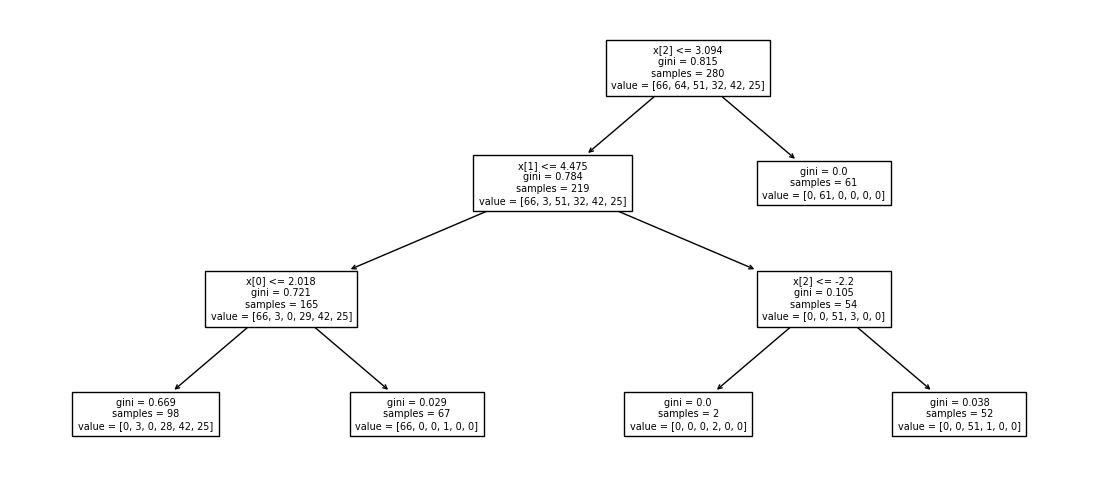

In [8]:
plt.figure(figsize=(14,6))
a = plot_tree(dtc_model, fontsize=7)

# Tuning decision tree 
Tune the depth of your decision tree. Does it improve the accuracy?  
(Optional) Do you get better results with your decision tree if you reduce the number of dimensions with PCA first?

In [9]:
dtc_model_tune = DecisionTreeClassifier(random_state=0)

params = {
    # 'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': np.arange(1, 31, 1),
}

grid_model = GridSearchCV(estimator=dtc_model_tune, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_model.fit(X_train, y_train)
print('Accuracy: {:.2f}'.format(grid_model.best_score_))
print('Best parameters {}'.format(grid_model.best_params_))

Accuracy: 0.72
Best parameters {'max_depth': 6}


In [10]:
best_dtc_model = grid_model.best_estimator_
best_dtc_model.fit(X_train, y_train)
accuracy = best_dtc_model.score(X_valid, y_valid)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.72


In [11]:
dtc_model_tune = DecisionTreeClassifier(random_state=0)

pipe_tune =  Pipeline([
    ('pca', PCA(random_state=0)),
    ('tree', dtc_model_tune)
])

### Tune max_depth and n_components
params = {
    'tree__max_depth': np.arange(1, 21, 1),
    'pca__n_components': np.arange(40, 61, 1),
    'tree__min_samples_split': [7],
    'tree__min_samples_leaf': [3],
    'tree__max_features': [None],
}

grid_model = GridSearchCV(estimator=pipe_tune, param_grid=params, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid_model.fit(X_train, y_train)
print('Accuracy: {:.2f}'.format(grid_model.best_score_))
print('Best parameters {}'.format(grid_model.best_params_))

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Accuracy: 0.88
Best parameters {'pca__n_components': 55, 'tree__max_depth': 7, 'tree__max_features': None, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 7}


In [12]:
best_pipe_model = grid_model.best_estimator_
best_pipe_model.fit(X_train, y_train)
accuracy = best_pipe_model.score(X_valid, y_valid)
print('Validation accuracy: {:.2f}'.format(accuracy))

Validation accuracy: 0.87


Even in this case, reducing the number of components, the model accuracy increases

In [13]:
print('Test accuracy: {:.2f}'.format(best_pipe_model.score(X_test, y_test)))

Test accuracy: 0.88


# Random Forest
Try a random forest model and tune the number of trees and their depth. Does increasing the number of trees help? Is there an optimal depth and how does it compare to your decision tree above?

In [14]:
### Define and fit a random forest classifier
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
### Compute the accuracy
accuracy = rf_model.score(X_valid, y_valid)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.88


In [15]:
rf_model_tune_trees = RandomForestClassifier(random_state=0)

params = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 500, 700, 1000],
}

grid_model = GridSearchCV(estimator=rf_model_tune_trees, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_model.fit(X_train, y_train)
print('Accuracy: {:.2f}'.format(grid_model.best_score_))
print('Best parameters {}'.format(grid_model.best_params_))

Accuracy: 0.88
Best parameters {'n_estimators': 500}


In [16]:
### Create a dictionary with the grid search results
score_columns = ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']
mydict = {x: grid_model.cv_results_[x] for x in score_columns}
mydict['C'] = grid_model.param_grid['n_estimators']
df = pd.DataFrame(mydict)

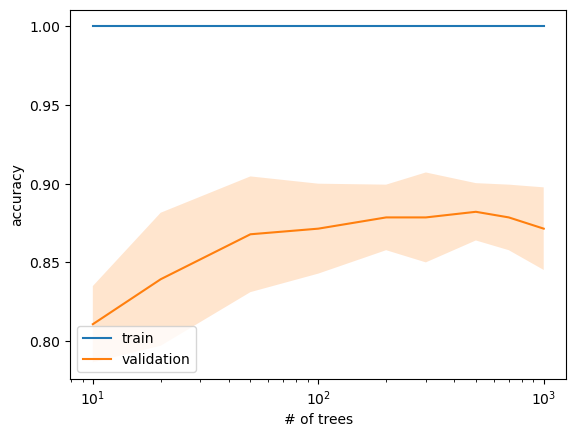

In [17]:
# Plot mean scores
plt.plot(df.C, df.mean_train_score, label="train")
plt.plot(df.C, df.mean_test_score, label="validation")

# Quantify variance with ±std curves
plt.fill_between(df.C, df.mean_train_score - df.std_train_score, df.mean_train_score + df.std_train_score, alpha=0.2)
plt.fill_between(df.C, df.mean_test_score - df.std_test_score, df.mean_test_score + df.std_test_score, alpha=0.2)
plt.xscale('log')
plt.ylabel("accuracy")
plt.xlabel("# of trees")
plt.legend()

As show in the plot above, training accuracy is constant increasing the number of trees, but the validation accuracy increses.  
The best number of trees is 500, with an accuracy of the 88%

Now, let's tune `n_estimators` and `max_depth`

In [18]:
rf_model_tune = RandomForestClassifier()

params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': np.arange(1, 11, 1),
    'random_state': [0]
}

grid_model = GridSearchCV(estimator=rf_model_tune, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_model.fit(X_train, y_train)
print('Accuracy: {:.2f}'.format(grid_model.best_score_))
print('Best parameters {}'.format(grid_model.best_params_))

Accuracy: 0.88
Best parameters {'max_depth': 6, 'n_estimators': 1000, 'random_state': 0}


In [19]:
best_rf_model = grid_model.best_estimator_
best_rf_model.fit(X_train, y_train)
accuracy = best_rf_model.score(X_valid, y_valid)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.87


Without PCA the optimal depth is 6

In [20]:
pipe_tune =  Pipeline([
    ('pca', PCA(random_state=0)),
    ('tree', rf_model_tune)
])

params = {
    'tree__n_estimators': [100, 500, 1000],
    'tree__max_depth': np.arange(1, 11, 1),
    'tree__random_state': [0],
    'pca__n_components': np.arange(40, 61, 5)
}

grid_model = GridSearchCV(estimator=pipe_tune, param_grid=params, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid_model.fit(X_train, y_train)
print('Accuracy: {:.2f}'.format(grid_model.best_score_))
print('Best parameters {}'.format(grid_model.best_params_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Accuracy: 0.89
Best parameters {'pca__n_components': 45, 'tree__max_depth': 8, 'tree__n_estimators': 500, 'tree__random_state': 0}


In [21]:
best_pipe_model = grid_model.best_estimator_
best_pipe_model.fit(X_train, y_train)
accuracy = best_pipe_model.score(X_valid, y_valid)
print('Validation accuracy: {:.2f}'.format(accuracy))

Validation accuracy: 0.90


Even using a Random Forest, reducing the number of features to 50 the accuracy increases

In [22]:
print('Test accuracy: {:.2f}'.format(best_pipe_model.score(X_test, y_test)))

Test accuracy: 0.96


# Feature importance 
The random forest estimator provides a ranking of the features according to their importance in the classification task via the `feature_importances_` attribute. Find the the top 5 important features and visualize their importance scores.

In [23]:
best_rf_model.feature_importances_

array([0.00195077, 0.00029371, 0.00020026, ..., 0.00019014, 0.00348188,
       0.00061738])

In [24]:
### Create a dataframe with the importance score of the features
df_features = pd.DataFrame(best_rf_model.feature_importances_, columns=['importance'])
df_features.head()

,importance
0,0.001951
1,0.000294
2,0.000200
3,0.000332
4,0.000379


In [25]:
### Print the top 5 important features
df_features.sort_values('importance', ascending=False)[:5]

,importance
783,0.011849
892,0.011769
1239,0.011626
999,0.011022
801,0.010460


<BarContainer object of 1280 artists>

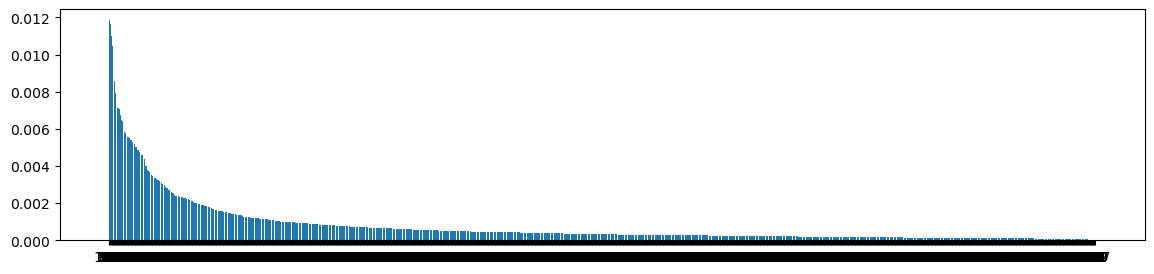

In [26]:
plt.figure(figsize=(14,3))
plt.bar(x=df_features.sort_values('importance', ascending=False).index.astype(str), 
        height=df_features.sort_values('importance', ascending=False).importance)

The 3 most important features have scores between 0.15 and 0.20.  
The 4th important feature has 0.055 as score.  
All the remaining features have score about or below 0.03

# Check the similarity with logistic regression and task 1
Are these top features similar to the ones you found based on the coefficients in the logistic regression task, and also during the data exploration in the last question of Task 1?

These features are not similar to the ones found in the previous tasks.